In [39]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from numpy import linalg as LA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [40]:
# Import Dataset
df = pd.read_csv('X_train.csv', sep='\s+')
# print(df)
Data = df.to_numpy()

# labels and size of dataset
sampleSize = Data.shape[0]          
Y = pd.read_csv('y_train.txt')
label = np.squeeze(Y.to_numpy())

In [41]:
# Normalizing data to apply PCA
Data = Data[:, 0:-2]
sc = StandardScaler()
Data = sc.fit_transform(Data)

# Reducing dimensions to obtain 10 principal components
pca = PCA(n_components = 10)
Data = pca.fit_transform(Data)

N_labels = 6            # Number of labels 
N_features = 10         # Number of features

In [42]:
# Compute Mean and Covariance matrices
meanMatrix = np.zeros(shape = [N_labels, N_features])
covarianceMatrix = np.zeros(shape = [N_labels, N_features, N_features])

for i in range(0, N_labels):
    meanMatrix[i, :] = np.mean(Data[(label == i + 1), :], axis = 0)
    covarianceMatrix[i, :, :] = np.cov(Data[(label == i + 1), :], rowvar = False)
    covarianceMatrix[i, :, :] += (0.00001) * ((np.trace(covarianceMatrix[i,:,:]))/LA.matrix_rank(covarianceMatrix[i,:,:])) * np.eye(10)
    #Check if covariance matrices are ill-conditioned
    #print(LA.cond(covariance_matrix[i,:,:]))

lossMatrix = np.ones(shape = [N_labels, N_labels]) - np.eye(N_labels)

# Compute class conditional PDF
P_x_L = np.zeros(shape = [N_labels, sampleSize])
for i in range(0, N_labels):
    P_x_L[i, :] = multivariate_normal.pdf(Data, mean = meanMatrix[i, :], cov = covarianceMatrix[i, :,:])

# Estimate class priors based on sample count
priors = np.zeros(shape = [N_labels, 1])
for i in range(0, N_labels):
    priors[i] = (np.size(label[np.where((label == i + 1))])) / sampleSize

# Compute Class Posteriors using priors and class conditional PDF
P_x = np.matmul(np.transpose(priors), P_x_L)
classPosteriors = (P_x_L * (np.matlib.repmat(priors, 1, sampleSize))) / np.matlib.repmat(P_x, N_labels, 1)

In [43]:
# expected risk and decisions based on minimum risk
expectedRisk = np.matmul(lossMatrix, classPosteriors)
decision = np.argmin(expectedRisk, axis = 0)
print("Average Expected Risk", np.sum(np.min(expectedRisk, axis = 0)) / sampleSize)

# calculating Confusion Matrix
confusionMatrix = np.zeros(shape = [N_labels, N_labels])
for d in range(N_labels):
    for l in range(N_labels):
        confusionMatrix[d, l] = (np.size(np.where((d == decision) & (l == label - 1)))) / np.size(np.where(label - 1 == l))

np.set_printoptions(suppress=True)
print(confusionMatrix)

Average Expected Risk 0.09745279149865901
[[0.90946166 0.02609506 0.02941176 0.         0.00145666 0.        ]
 [0.05791191 0.91798695 0.14604462 0.00155521 0.         0.        ]
 [0.03262643 0.05591799 0.82454361 0.         0.         0.00071073]
 [0.         0.         0.         0.58164852 0.08302986 0.03056148]
 [0.         0.         0.         0.37791602 0.91260015 0.        ]
 [0.         0.         0.         0.03888025 0.00291333 0.96872779]]


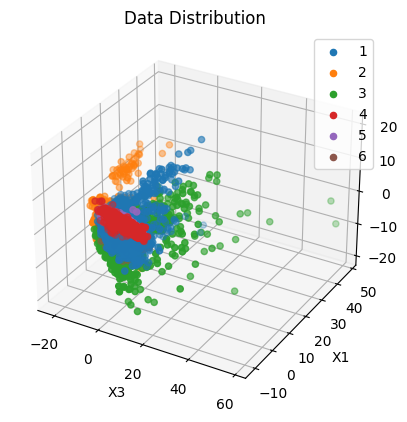

In [44]:
# Plot Data Distribution
fig = plt.figure()
ax = plt.axes(projection = "3d")
for i in range(1, N_labels + 1):
    ax.scatter(Data[(label==i),1],Data[(label==i),2],Data[(label==i),3], label=i)
plt.xlabel('X3')
plt.ylabel('X1')
ax.set_zlabel('X2')
ax.legend()
plt.title('Data Distribution')
plt.show()